In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io
import os

In [4]:
zip_file_name = "2025-04.zip"
csv_file_name = "2025-04.csv"

# Descomprimir el archivo ZIP si existe
if os.path.exists(zip_file_name):
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extract(csv_file_name)
    print(f"Archivo {csv_file_name} extraído correctamente.")
else:
    print(f"No se encontró el archivo ZIP: {zip_file_name}")

# Leer el archivo CSV extraído
print(f"Leyendo datos desde archivo local: {csv_file_name}")
try:
    df_raw = pd.read_csv(csv_file_name)
    print("Lectura completada con éxito")
except Exception as e:
    print(f"Error al leer el archivo: {e}")
    df_raw = pd.DataFrame()

Archivo 2025-04.csv extraído correctamente.
Leyendo datos desde archivo local: 2025-04.csv
Lectura completada con éxito
Lectura completada con éxito


In [5]:
df_raw.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo
0,F,22.0,2586485,107-108,31/03/2025,23:34:46,181,01/04/2025,00:00:12
1,M,50.0,8152522,384,31/03/2025,23:43:51,387,01/04/2025,00:00:16
2,M,24.0,4219945,021,31/03/2025,23:42:36,548,01/04/2025,00:00:23
3,M,32.0,2286540,271-272,31/03/2025,23:57:16,450,01/04/2025,00:00:31
4,M,26.0,5017868,538,31/03/2025,23:46:23,012,01/04/2025,00:00:31


In [6]:
# Crear la columna de duración del viaje en minutos
if 'df_raw' in locals() and not df_raw.empty:
    if 'Fecha_Retiro' in df_raw.columns and 'Hora_Retiro' in df_raw.columns and 'Fecha_Arribo' in df_raw.columns and 'Hora_Arribo' in df_raw.columns:
        # Unir fecha y hora para obtener el datetime completo
        df_raw['Fecha_origen_recorrido'] = pd.to_datetime(df_raw['Fecha_Retiro'] + ' ' + df_raw['Hora_Retiro'], dayfirst=True)
        df_raw['Fecha_destino_recorrido'] = pd.to_datetime(df_raw['Fecha_Arribo'] + ' ' + df_raw['Hora_Arribo'], dayfirst=True)
        df_raw['Duracion_minutos'] = (df_raw['Fecha_destino_recorrido'] - df_raw['Fecha_origen_recorrido']).dt.total_seconds() / 60
        print("Columna 'Duracion_minutos' creada en minutos usando Fecha/Hora de Retiro y Arribo.")
    else:
        print("No se encontraron columnas adecuadas para calcular la duración.")
else:
    print("No hay datos disponibles para crear la columna de duración.")

Columna 'Duracion_minutos' creada en minutos usando Fecha/Hora de Retiro y Arribo.


In [7]:
# Eliminar columnas de fecha y hora que ya no son necesarias
df_raw = df_raw.drop(['Fecha_Retiro', 'Hora_Retiro', 'Fecha_Arribo', 'Hora_Arribo'], axis=1)
print('Columnas de fecha y hora eliminadas.')

Columnas de fecha y hora eliminadas.


In [8]:
# Clasificar los viajes por duración: corto, medio, largo
def clasificar_viaje(minutos):
    if minutos <= 10:
        return 'Corto'
    elif minutos <= 25:
        return 'Medio'
    else:
        return 'Largo'
df_raw['Tipo_viaje'] = df_raw['Duracion_minutos'].apply(clasificar_viaje)
print('Columna Tipo_viaje agregada.')

# Mostrar el conteo de valores en la columna 'Tipo_viaje'
print("\nConteo de viajes por categoría de duración:")
print(df_raw['Tipo_viaje'].value_counts())

Columna Tipo_viaje agregada.

Conteo de viajes por categoría de duración:
Tipo_viaje
Medio    747951
Corto    693567
Largo    286469
Name: count, dtype: int64


In [9]:
df_raw.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Ciclo_EstacionArribo,Fecha_origen_recorrido,Fecha_destino_recorrido,Duracion_minutos,Tipo_viaje
0,F,22.0,2586485,107-108,181,2025-03-31 23:34:46,2025-04-01 00:00:12,25.433333,Largo
1,M,50.0,8152522,384,387,2025-03-31 23:43:51,2025-04-01 00:00:16,16.416667,Medio
2,M,24.0,4219945,021,548,2025-03-31 23:42:36,2025-04-01 00:00:23,17.783333,Medio
3,M,32.0,2286540,271-272,450,2025-03-31 23:57:16,2025-04-01 00:00:31,3.250000,Corto
4,M,26.0,5017868,538,012,2025-03-31 23:46:23,2025-04-01 00:00:31,14.133333,Medio


In [10]:
# Viajes atípicos: duración mayor a 1 hora
if 'df_raw' in locals() and not df_raw.empty:
    # Asegúrate de usar el nombre correcto de la columna de duración
    viajes_atipicos = df_raw[df_raw['Duracion_minutos'] > 60]
    print(f"Viajes atípicos encontrados: {len(viajes_atipicos)}")
    display(viajes_atipicos.head())
else:
    print("No hay datos disponibles para analizar viajes atípicos.")

Viajes atípicos encontrados: 7871


,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Ciclo_EstacionArribo,Fecha_origen_recorrido,Fecha_destino_recorrido,Duracion_minutos,Tipo_viaje
23,M,36.0,3715992,126,477,2025-03-31 21:54:33,2025-04-01 00:02:33,128.000000,Largo
27,M,27.0,3922341,052,477,2025-03-31 22:58:29,2025-04-01 00:02:50,64.350000,Largo
39,M,37.0,2128213,032,032,2025-03-31 22:58:45,2025-04-01 00:03:34,64.816667,Largo
42,?,27.0,6846612,052,477,2025-03-31 22:53:55,2025-04-01 00:03:46,69.850000,Largo
245,?,26.0,8280224,336,025,2025-03-31 22:31:18,2025-04-01 00:34:45,123.450000,Largo



Visualización de la distribución de 'Genero_Usuario':

Conteo de viajes por género:
Genero_Usuario
M    1177624
F     484899
O      32835
?      32628
Name: count, dtype: int64


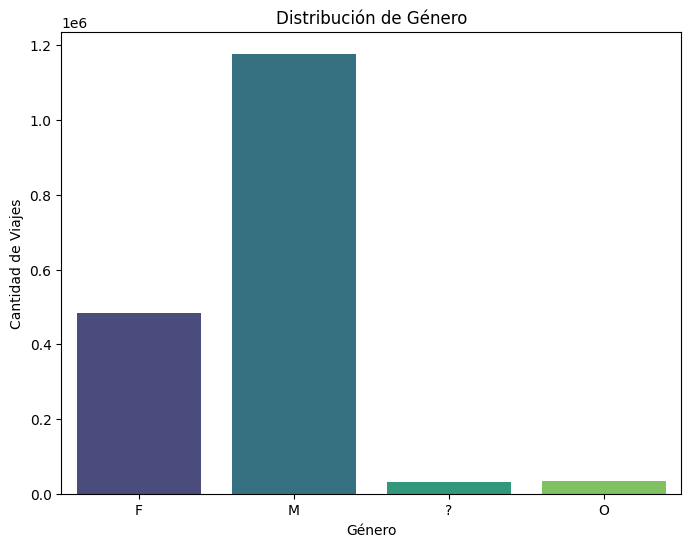

In [11]:
# Visualizar la distribución de la variable categórica 'Genero_Usuario'
print("\nVisualización de la distribución de 'Genero_Usuario':")
print("\nConteo de viajes por género:")
print(df_raw['Genero_Usuario'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(data=df_raw, x='Genero_Usuario', palette='viridis', hue='Genero_Usuario', legend=False)
plt.title('Distribución de Género')
plt.xlabel('Género')
plt.ylabel('Cantidad de Viajes')
plt.show()

In [12]:
# Limpieza de Genero
df_raw['Genero_Usuario'] = df_raw['Genero_Usuario'].replace(['OTHER', '?'], 'O')
print("Valores 'OTHER' y '?' en 'Genero_Usuario' reemplazados por 'O'.")

Valores 'OTHER' y '?' en 'Genero_Usuario' reemplazados por 'O'.



Visualización de la distribución de 'Genero_Usuario':

Conteo de viajes por género:
Genero_Usuario
M    1177624
F     484899
O      65463
Name: count, dtype: int64


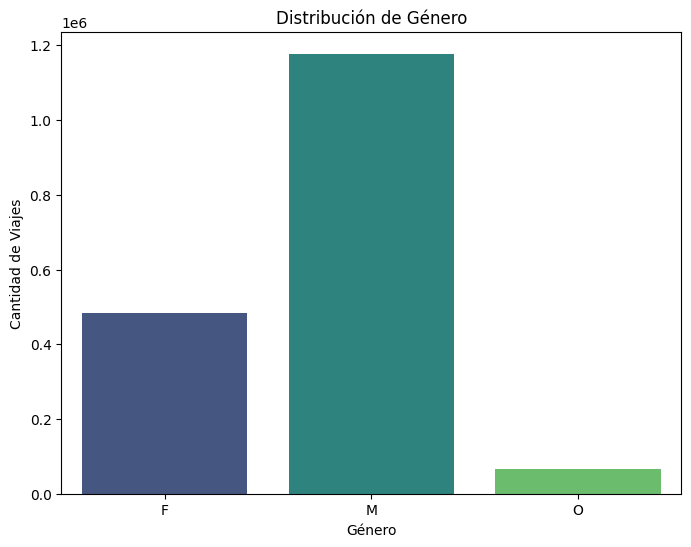

In [13]:
# Visualizar la distribución de la variable categórica 'Genero_Usuario'
print("\nVisualización de la distribución de 'Genero_Usuario':")
print("\nConteo de viajes por género:")
print(df_raw['Genero_Usuario'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(data=df_raw, x='Genero_Usuario', palette='viridis', hue='Genero_Usuario', legend=False)
plt.title('Distribución de Género')
plt.xlabel('Género')
plt.ylabel('Cantidad de Viajes')
plt.show()

#### Predicción

In [14]:
# Ejemplo de regresión lineal para predecir la duración del viaje en todo el dataset
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Seleccionar variables predictoras (puedes agregar más según tu análisis)
X = df_raw[['Edad_Usuario', 'Genero_Usuario', 'Ciclo_Estacion_Retiro', 'Ciclo_EstacionArribo']].copy()
y = df_raw['Duracion_minutos']

# Imputar valores nulos en las variables predictoras
X['Edad_Usuario'] = X['Edad_Usuario'].fillna(X['Edad_Usuario'].median())
X['Genero_Usuario'] = X['Genero_Usuario'].fillna('O')
X['Ciclo_Estacion_Retiro'] = X['Ciclo_Estacion_Retiro'].fillna('Unknown')
X['Ciclo_EstacionArribo'] = X['Ciclo_EstacionArribo'].fillna('Unknown')

# Codificar variables categóricas
le_genero = LabelEncoder()
X['Genero_Usuario'] = le_genero.fit_transform(X['Genero_Usuario'])
le_retiro = LabelEncoder()
X['Ciclo_Estacion_Retiro'] = le_retiro.fit_transform(X['Ciclo_Estacion_Retiro'].astype(str))
le_arribo = LabelEncoder()
X['Ciclo_EstacionArribo'] = le_arribo.fit_transform(X['Ciclo_EstacionArribo'].astype(str))

# Entrenar el modelo con todo el dataset
modelo = LinearRegression()
modelo.fit(X, y)

# Predecir para todo el dataset
df_raw['Duracion_predicha'] = modelo.predict(X)
print('Columna Duracion_predicha agregada para todo el dataset.')

# Mostrar algunas predicciones
print("Predicciones de duración (minutos):")
print(np.round(df_raw['Duracion_predicha'].head(10), 2))

Columna Duracion_predicha agregada para todo el dataset.
Predicciones de duración (minutos):
0    20.87
1    15.39
2    14.68
3    15.46
4    19.73
5    17.06
6    13.13
7    19.10
8    18.07
9    18.17
Name: Duracion_predicha, dtype: float64


   Duracion_real  Duracion_predicha
0      25.433333          20.872125
1      16.416667          15.385475
2      17.783333          14.679902
3       3.250000          15.461239
4      14.133333          19.727706
5      18.900000          17.060613
6      10.400000          13.127920
7      13.450000          19.100133
8       5.800000          18.073058
9       8.716667          18.171715


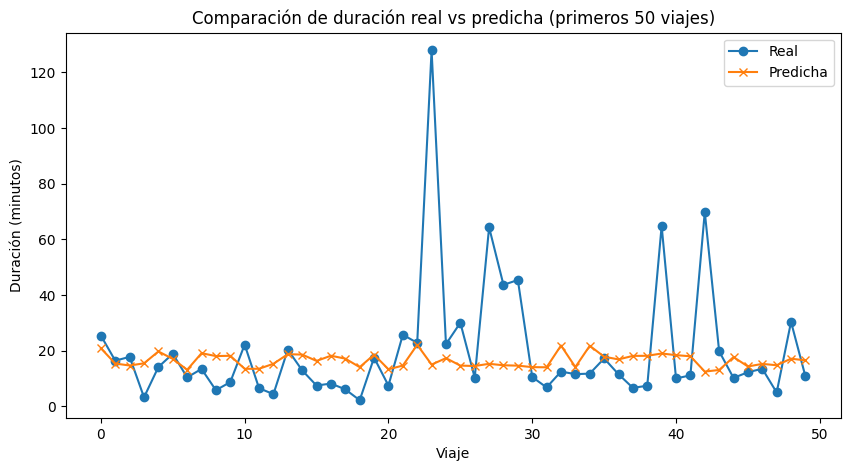

In [15]:
# Comparar duración real vs predicha para todo el dataset
comparacion = pd.DataFrame({'Duracion_real': df_raw['Duracion_minutos'], 'Duracion_predicha': df_raw['Duracion_predicha']})
print(comparacion.head(10))

plt.figure(figsize=(10,5))
plt.plot(comparacion['Duracion_real'].values[:50], label='Real', marker='o')
plt.plot(comparacion['Duracion_predicha'].values[:50], label='Predicha', marker='x')
plt.title('Comparación de duración real vs predicha (primeros 50 viajes)')
plt.xlabel('Viaje')
plt.ylabel('Duración (minutos)')
plt.legend()
plt.show()

In [16]:
df_raw.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Ciclo_EstacionArribo,Fecha_origen_recorrido,Fecha_destino_recorrido,Duracion_minutos,Tipo_viaje,Duracion_predicha
0,F,22.0,2586485,107-108,181,2025-03-31 23:34:46,2025-04-01 00:00:12,25.433333,Largo,20.872125
1,M,50.0,8152522,384,387,2025-03-31 23:43:51,2025-04-01 00:00:16,16.416667,Medio,15.385475
2,M,24.0,4219945,021,548,2025-03-31 23:42:36,2025-04-01 00:00:23,17.783333,Medio,14.679902
3,M,32.0,2286540,271-272,450,2025-03-31 23:57:16,2025-04-01 00:00:31,3.250000,Corto,15.461239
4,M,26.0,5017868,538,012,2025-03-31 23:46:23,2025-04-01 00:00:31,14.133333,Medio,19.727706


La predicción de la duración del viaje en esta base de datos es difícil porque faltan variables clave que influyen en el tiempo real de recorrido, como el tráfico, clima, eventos, condiciones de la bicicleta, y rutas tomadas. Además, los datos pueden contener valores atípicos, errores de registro y poca información sobre el contexto de cada viaje. Las variables disponibles (edad, género, estaciones) explican solo una parte del comportamiento, por lo que el modelo no puede capturar la complejidad real del fenómeno y su precisión es limitada.

In [ ]:
# Guardar el DataFrame en CSV y Parquet
if not df_raw.empty:
    guardado_csv = False
    guardado_parquet = False
    # Guardar como un nuevo archivo CSV.
    try:
        df_raw.to_csv("viajes_ecobici_cdmx.csv", index=False)
        guardado_csv = True
    except Exception as e:
        print(f"Error al guardar el archivo CSV: {e}")
    # Guardar en formato Parquet.
    try:
        df_raw.to_parquet("viajes_ecobici_cdmx.parquet", index=False)
        guardado_parquet = True
    except Exception as e:
        print(f"Error al guardar el archivo Parquet: {e}")
    if guardado_csv:
        print("DataFrame guardado exitosamente en 'viajes_ecobici_cdmx.csv'")
    if guardado_parquet:
        print("DataFrame guardado exitosamente en 'viajes_ecobici_cdmx.parquet'")

DataFrame guardado exitosamente en 'viajes_ecobici_cdmx.csv'
DataFrame guardado exitosamente en 'viajes_ecobici_cdmx.parquet'
